## UNet网络结构

本案例参考来源于Paddle官方文档，可[前往此处](https://www.paddlepaddle.org.cn/documentation/docs/zh/2.0-rc1/tutorial/cv_case/image_segmentation/image_segmentation.html)查看官方案例，由于本地显存资源有限，这里使用**Baidu AIStudio**进行运算，AIStudio提供了高性能的`Tesla V100`计算卡，可以通过`nvidia-smi`查看显卡信息

In [1]:
!nvidia-smi

Tue Jan 19 18:05:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:09.0 Off |                    0 |
| N/A   36C    P0    59W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

UNet原始论文的解读可以参见我之前的一篇博客[【飞桨】Seg：U-Net【2015 MICCAI】论文研读](https://blog.csdn.net/qq_39567427/article/details/109281668)

## 数据集下载

本案例使用Oxford-IIIT Pet数据集，点击此处进入[数据集官网](https://www.robots.ox.ac.uk/~vgg/data/pets)

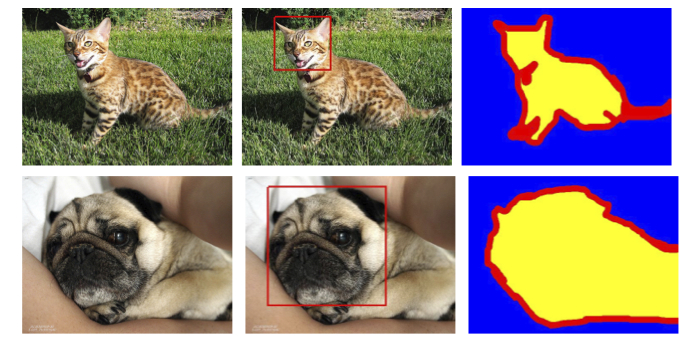

可通过如下命令下载并解压数据集
```shell
wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
tar -xf images.tar.gz
tar -xf annotations.tar.gz
```

## 导入必要的包

In [ ]:
import os
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import paddle
from paddle.nn import functional as F
import random
from paddle.io import Dataset
from visualdl import LogWriter
from paddle.vision.transforms import transforms as T
import warnings
warnings.filterwarnings("ignore")

paddle.seed(7)

paddle.__version__

'2.0.0-rc1'

## 数据处理
生成`train.txt`，`test.txt`，以及`predict.txt`

In [ ]:
IMAGE_SIZE = (160, 160)
train_images_path = "images/"
label_images_path = "annotations/trimaps/"
image_count = len([os.path.join(train_images_path, image_name)
          for image_name in os.listdir(train_images_path)
          if image_name.endswith('.jpg')])
print("Train Samples:", image_count)

def _sort_images(image_dir, image_type):
    files = []

    for image_name in os.listdir(image_dir):
        if image_name.endswith('.{}'.format(image_type)) \
                and not image_name.startswith('.'):
            files.append(os.path.join(image_dir, image_name))

    return sorted(files)

def write_file(mode, images, labels):
    with open('./{}.txt'.format(mode), 'w') as f:
        for i in range(len(images)):
            f.write('{}\t{}\n'.format(images[i], labels[i]))

images = _sort_images(train_images_path, 'jpg')
labels = _sort_images(label_images_path, 'png')
eval_num = int(image_count * 0.15)

write_file('train', images[:-eval_num], labels[:-eval_num])
write_file('test', images[-eval_num:], labels[-eval_num:])
write_file('predict', images[-eval_num:], labels[-eval_num:])


Train Samples: 7390


可视化部分数据

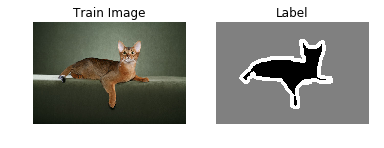

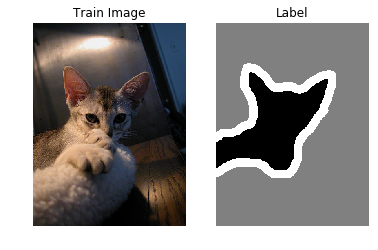

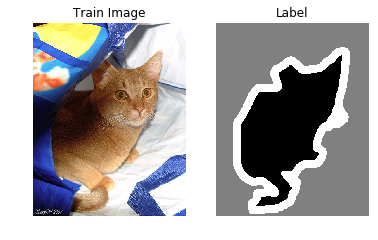

In [ ]:
with open('./train.txt', 'r') as f:
    i = 0

    for line in f.readlines():
        image_path, label_path = line.strip().split('\t')
        image = np.array(Image.open(image_path))
        label = np.array(Image.open(label_path))

        if i > 2:
            break
        plt.figure()

        plt.subplot(1,2,1),
        plt.title('Train Image')
        plt.imshow(image.astype('uint8'))
        plt.axis('off')

        plt.subplot(1,2,2),
        plt.title('Label')
        plt.imshow(label.astype('uint8'), cmap='gray')
        plt.axis('off')

        plt.show()
        i = i + 1


## 数据装载

In [ ]:
class PetDataset(Dataset):
    def __init__(self, mode='train'):
        self.image_size = IMAGE_SIZE
        self.mode = mode.lower()

        assert self.mode in ['train', 'test', 'predict'], \
            "mode should be 'train' or 'test' or 'predict', but got {}".format(self.mode)

        self.train_images = []
        self.label_images = []

        with open('./{}.txt'.format(self.mode), 'r') as f:
            for line in f.readlines():
                image, label = line.strip().split('\t')
                self.train_images.append(image)
                self.label_images.append(label)

    def _load_img(self, path, color_mode='rgb', transforms=[]):
        with open(path, 'rb') as f:
            img = Image.open(io.BytesIO(f.read()))
            if color_mode == 'grayscale':
                # if image is not already an 8-bit, 16-bit or 32-bit grayscale image
                # convert it to an 8-bit grayscale image.
                if img.mode not in ('L', 'I;16', 'I'):
                    img = img.convert('L')
            elif color_mode == 'rgba':
                if img.mode != 'RGBA':
                    img = img.convert('RGBA')
            elif color_mode == 'rgb':
                if img.mode != 'RGB':
                    img = img.convert('RGB')
            else:
                raise ValueError('color_mode must be "grayscale", "rgb", or "rgba"')

            return T.Compose([
                T.Resize(self.image_size)
            ] + transforms)(img)

    def __getitem__(self, idx):
        train_image = self._load_img(self.train_images[idx],
                                     transforms=[
                                         T.Transpose(),
                                         T.Normalize(mean=127.5, std=127.5)
                                     ])
        label_image = self._load_img(self.label_images[idx],
                                     color_mode='grayscale',
                                     transforms=[T.Grayscale()])

        # 返回image, label
        train_image = np.array(train_image, dtype='float32')
        label_image = np.array(label_image, dtype='int64')
        return train_image, label_image

    def __len__(self):
        return len(self.train_images)


## 建模训练

### 定义UNet结构

In [ ]:
from paddle.nn import functional as F

class SeparableConv2D(paddle.nn.Layer):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 dilation=1,
                 groups=None,
                 weight_attr=None,
                 bias_attr=None,
                 data_format="NCHW"):
        super(SeparableConv2D, self).__init__()

        self._padding = padding
        self._stride = stride
        self._dilation = dilation
        self._in_channels = in_channels
        self._data_format = data_format

        # 第一次卷积参数，没有偏置参数
        filter_shape = [in_channels, 1] + self.convert_to_list(kernel_size, 2, 'kernel_size')
        self.weight_conv = self.create_parameter(shape=filter_shape, attr=weight_attr)

        # 第二次卷积参数
        filter_shape = [out_channels, in_channels] + self.convert_to_list(1, 2, 'kernel_size')
        self.weight_pointwise = self.create_parameter(shape=filter_shape, attr=weight_attr)
        self.bias_pointwise = self.create_parameter(shape=[out_channels],
                                                    attr=bias_attr,
                                                    is_bias=True)

    def convert_to_list(self, value, n, name, dtype=np.int):
        if isinstance(value, dtype):
            return [value, ] * n
        else:
            try:
                value_list = list(value)
            except TypeError:
                raise ValueError("The " + name +
                                "'s type must be list or tuple. Received: " + str(
                                    value))
            if len(value_list) != n:
                raise ValueError("The " + name + "'s length must be " + str(n) +
                                ". Received: " + str(value))
            for single_value in value_list:
                try:
                    dtype(single_value)
                except (ValueError, TypeError):
                    raise ValueError(
                        "The " + name + "'s type must be a list or tuple of " + str(
                            n) + " " + str(dtype) + " . Received: " + str(
                                value) + " "
                        "including element " + str(single_value) + " of type" + " "
                        + str(type(single_value)))
            return value_list

    def forward(self, inputs):
        conv_out = F.conv2d(inputs,
                            self.weight_conv,
                            padding=self._padding,
                            stride=self._stride,
                            dilation=self._dilation,
                            groups=self._in_channels,
                            data_format=self._data_format)

        out = F.conv2d(conv_out,
                       self.weight_pointwise,
                       bias=self.bias_pointwise,
                       padding=0,
                       stride=1,
                       dilation=1,
                       groups=1,
                       data_format=self._data_format)

        return out

定义编码器

In [ ]:
class Encoder(paddle.nn.Layer):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()

        self.relus = paddle.nn.LayerList(
            [paddle.nn.ReLU() for i in range(2)])
        self.separable_conv_01 = SeparableConv2D(in_channels,
                                                 out_channels,
                                                 kernel_size=3,
                                                 padding='same')
        self.bns = paddle.nn.LayerList(
            [paddle.nn.BatchNorm2D(out_channels) for i in range(2)])

        self.separable_conv_02 = SeparableConv2D(out_channels,
                                                 out_channels,
                                                 kernel_size=3,
                                                 padding='same')
        self.pool = paddle.nn.MaxPool2D(kernel_size=3, stride=2, padding=1)
        self.residual_conv = paddle.nn.Conv2D(in_channels,
                                              out_channels,
                                              kernel_size=1,
                                              stride=2,
                                              padding='same')

    def forward(self, inputs):
        previous_block_activation = inputs

        y = self.relus[0](inputs)
        y = self.separable_conv_01(y)
        y = self.bns[0](y)
        y = self.relus[1](y)
        y = self.separable_conv_02(y)
        y = self.bns[1](y)
        y = self.pool(y)

        residual = self.residual_conv(previous_block_activation)
        y = paddle.add(y, residual)

        return y

定义解码器

In [ ]:
class Decoder(paddle.nn.Layer):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()

        self.relus = paddle.nn.LayerList(
            [paddle.nn.ReLU() for i in range(2)])
        self.conv_transpose_01 = paddle.nn.Conv2DTranspose(in_channels,
                                                           out_channels,
                                                           kernel_size=3,
                                                           padding=1)
        self.conv_transpose_02 = paddle.nn.Conv2DTranspose(out_channels,
                                                           out_channels,
                                                           kernel_size=3,
                                                           padding=1)
        self.bns = paddle.nn.LayerList(
            [paddle.nn.BatchNorm2D(out_channels) for i in range(2)]
        )
        self.upsamples = paddle.nn.LayerList(
            [paddle.nn.Upsample(scale_factor=2.0) for i in range(2)]
        )
        self.residual_conv = paddle.nn.Conv2D(in_channels,
                                              out_channels,
                                              kernel_size=1,
                                              padding='same')

    def forward(self, inputs):
        previous_block_activation = inputs

        y = self.relus[0](inputs)
        y = self.conv_transpose_01(y)
        y = self.bns[0](y)
        y = self.relus[1](y)
        y = self.conv_transpose_02(y)
        y = self.bns[1](y)
        y = self.upsamples[0](y)

        residual = self.upsamples[1](previous_block_activation)
        residual = self.residual_conv(residual)

        y = paddle.add(y, residual)

        return y


组网构建

In [ ]:
class PetNet(paddle.nn.Layer):
    def __init__(self, num_classes):
        super(PetNet, self).__init__()

        self.conv_1 = paddle.nn.Conv2D(3, 32,
                                       kernel_size=3,
                                       stride=2,
                                       padding='same')
        self.bn = paddle.nn.BatchNorm2D(32)
        self.relu = paddle.nn.ReLU()

        in_channels = 32
        self.encoders = []
        self.encoder_list = [64, 128, 256]
        self.decoder_list = [256, 128, 64, 32]

        for out_channels in self.encoder_list:
            block = self.add_sublayer('encoder_{}'.format(out_channels),
                                      Encoder(in_channels, out_channels))
            self.encoders.append(block)
            in_channels = out_channels

        self.decoders = []

        for out_channels in self.decoder_list:
            block = self.add_sublayer('decoder_{}'.format(out_channels),
                                      Decoder(in_channels, out_channels))
            self.decoders.append(block)
            in_channels = out_channels

        self.output_conv = paddle.nn.Conv2D(in_channels,
                                            num_classes,
                                            kernel_size=3,
                                            padding='same')

    def forward(self, inputs):
        y = self.conv_1(inputs)
        y = self.bn(y)
        y = self.relu(y)

        for encoder in self.encoders:
            y = encoder(y)

        for decoder in self.decoders:
            y = decoder(y)

        y = self.output_conv(y)
        return y

查看网络结构

In [ ]:
num_classes = 37
network = PetNet(num_classes)
model = paddle.Model(network)
model.summary((-1, 3,) + IMAGE_SIZE)

-----------------------------------------------------------------------------
  Layer (type)        Input Shape          Output Shape         Param #    
    Conv2D-1       [[1, 3, 160, 160]]    [1, 32, 80, 80]          896      
  BatchNorm2D-1    [[1, 32, 80, 80]]     [1, 32, 80, 80]          128      
     ReLU-1        [[1, 32, 80, 80]]     [1, 32, 80, 80]           0       
     ReLU-2        [[1, 32, 80, 80]]     [1, 32, 80, 80]           0       
SeparableConv2D-1  [[1, 32, 80, 80]]     [1, 64, 80, 80]         2,400     
  BatchNorm2D-2    [[1, 64, 80, 80]]     [1, 64, 80, 80]          256      
     ReLU-3        [[1, 64, 80, 80]]     [1, 64, 80, 80]           0       
SeparableConv2D-2  [[1, 64, 80, 80]]     [1, 64, 80, 80]         4,736     
  BatchNorm2D-3    [[1, 64, 80, 80]]     [1, 64, 80, 80]          256      
   MaxPool2D-1     [[1, 64, 80, 80]]     [1, 64, 40, 40]           0       
    Conv2D-2       [[1, 32, 80, 80]]     [1, 64, 40, 40]         2,112     
    Encode

{'total_params': 2068805, 'trainable_params': 2061253}

### 定义彩色映射函数

定义`get_color_map_list`函数，将单通道标签映射成彩色图像

In [ ]:
def get_color_map_list(num_classes):
    color_map = num_classes * [0, 0, 0]
    for i in range(0, num_classes):
        j = 0
        lab = i
        while lab:
            color_map[i * 3] |= (((lab >> 0) & 1) << (7 - j))
            color_map[i * 3 + 1] |= (((lab >> 1) & 1) << (7 - j))
            color_map[i * 3 + 2] |= (((lab >> 2) & 1) << (7 - j))
            j += 1
            lab >>= 3

    return color_map

In [ ]:
color_map = get_color_map_list(37)

装载数据

In [ ]:
train_dataset = PetDataset(mode='train')
val_dataset = PetDataset(mode='test')

train_loader = paddle.io.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = paddle.io.DataLoader(val_dataset, batch_size=64, shuffle=True)

### 定义评价函数
计算`acc`以及`iou`等

In [ ]:
def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * label_true[mask].astype(int) +
        label_pred[mask], minlength=n_class ** 2).reshape(n_class, n_class)
    return hist


def label_accuracy_score(label_trues, label_preds, n_class):
    """Returns accuracy score evaluation result.
      - overall accuracy
      - mean accuracy
      - mean IU
      - fwavacc
    """
    hist = np.zeros((n_class, n_class))
    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    acc = np.diag(hist).sum() / hist.sum()
    with np.errstate(divide='ignore', invalid='ignore'):
        acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)
    with np.errstate(divide='ignore', invalid='ignore'):
        iu = np.diag(hist) / (
            hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist)
        )
    mean_iu = np.nanmean(iu)
    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    return acc, acc_cls, mean_iu, fwavacc

### 开始训练

In [ ]:
print('start training ... ')

EPOCH_NUM = 20
BATCH_SIZE = 64
train_num = 0

visual_IMAGE = Image.open('images/samoyed_174.jpg').resize((160, 160)).convert('RGBA')
visual_img = np.array(Image.open('images/samoyed_174.jpg').resize((160, 160)))
optimizer = paddle.optimizer.RMSProp(learning_rate=0.001, parameters=network.parameters())
normlize = (visual_img-127.5)/127.5
input = paddle.to_tensor([normlize.transpose(2, 0, 1)])

with LogWriter(logdir="./log") as writer:
    i = 0
    j = 0
    for epoch_id in range(EPOCH_NUM):
        loss_list_each_epoch = []
        network.train()
        for data, label in train_loader:
            i += 1
            y_pred = network(data)
            loss = F.cross_entropy(y_pred, label=label, axis=1)
            train_loss = loss.numpy()[0]
            loss.backward()
            optimizer.step()
            optimizer.clear_grad()
            predict_label = paddle.argmax(network(input)[0], axis=0).numpy().astype('uint8')
            pred_mask = Image.fromarray(predict_label, mode='P')
            pred_mask.putpalette(color_map)
            image = Image.blend(visual_IMAGE, pred_mask.convert('RGBA'), 0.3)
            acc, acc_cls, mean_iu, fwavacc =label_accuracy_score(label.numpy(), np.argmax(y_pred.numpy(), axis=1), 37)
            writer.add_image(tag="training Image", img=np.array(image), step=i)
            writer.add_scalar(tag="train/loss", step=i, value=train_loss)
            writer.add_scalar(tag="train/acc", step=i, value=acc)
            writer.add_scalar(tag="train/acc_cls", step=i, value=acc_cls)
            writer.add_scalar(tag="train/mean_iu", step=i, value=mean_iu)
            writer.add_scalar(tag="train/fwavacc", step=i, value=fwavacc)
            loss_list_each_epoch.append(train_loss)
        network.eval()
        val_loss_list_each_epoch = []
        for data, label in val_loader:
            j += 1
            y_pred = network(data)
            loss = F.cross_entropy(y_pred, label=label, axis=1)
            val_loss = loss.numpy()[0]
            acc, acc_cls, mean_iu, fwavacc =label_accuracy_score(label.numpy(), np.argmax(y_pred.numpy(), axis=1), 37)
            val_loss_list_each_epoch.append(val_loss)
            writer.add_scalar(tag="val/loss", step=j, value=val_loss)
            writer.add_scalar(tag="val/acc", step=j, value=acc)
            writer.add_scalar(tag="val/acc_cls", step=j, value=acc_cls)
            writer.add_scalar(tag="val/mean_iu", step=j, value=mean_iu)
            writer.add_scalar(tag="val/fwavacc", step=j, value=fwavacc)
        print("INFO:%d,Train Loss:%0.5f, Val Loss:%0.5f"%(epoch_id +1, np.average(loss_list_each_epoch), np.average(val_loss_list_each_epoch)))

start training ... 
INFO:1,Train Loss:4.74671, Val Loss:1.67874
INFO:2,Train Loss:1.16324, Val Loss:0.80919
INFO:3,Train Loss:0.82399, Val Loss:0.88417
INFO:4,Train Loss:0.77103, Val Loss:0.89409
INFO:5,Train Loss:0.66883, Val Loss:0.67590
INFO:6,Train Loss:0.57706, Val Loss:0.65639
INFO:7,Train Loss:0.53680, Val Loss:0.59634
INFO:8,Train Loss:0.49761, Val Loss:0.80708
INFO:9,Train Loss:0.48943, Val Loss:0.57200
INFO:10,Train Loss:0.45653, Val Loss:0.50049
INFO:11,Train Loss:0.43865, Val Loss:0.55012
INFO:12,Train Loss:0.42560, Val Loss:0.44346
INFO:13,Train Loss:0.40579, Val Loss:0.57764
INFO:14,Train Loss:0.39897, Val Loss:0.73057
INFO:15,Train Loss:0.38686, Val Loss:0.51803
INFO:16,Train Loss:0.37465, Val Loss:0.58165
INFO:17,Train Loss:0.36416, Val Loss:0.64811
INFO:18,Train Loss:0.34834, Val Loss:0.44253
INFO:19,Train Loss:0.34193, Val Loss:0.48618
INFO:20,Train Loss:0.33029, Val Loss:0.41588


## 模型预测及可视化

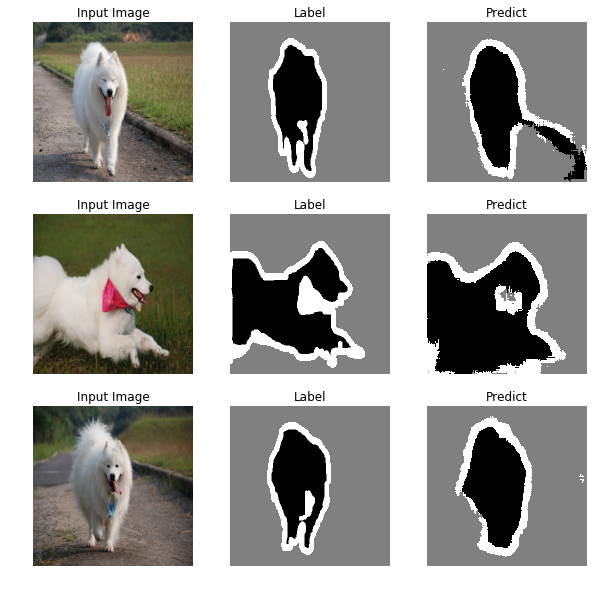

In [ ]:
plt.figure(figsize=(10, 10))

i = 0
mask_idx = 0

with open('./predict.txt', 'r') as f:
    for line in f.readlines():
        image_path, label_path = line.strip().split('\t')
        resize_t = T.Compose([
            T.Resize(IMAGE_SIZE)
        ])
        image = resize_t(Image.open(image_path))
        label = resize_t(Image.open(label_path))

        image = np.array(image).astype('uint8')
        label = np.array(label).astype('uint8')

        if i > 8:
            break
        plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title('Input Image')
        plt.axis("off")

        plt.subplot(3, 3, i + 2)
        plt.imshow(label, cmap='gray')
        plt.title('Label')
        plt.axis("off")

        # 模型只有一个输出，所以我们通过predict_results[0]来取出1000个预测的结果
        # 映射原始图片的index来取出预测结果，提取mask进行展示
        mask = paddle.argmax(network(paddle.to_tensor([((image - 127.5) / 127.5).transpose(2, 0, 1)]))[0], axis=0).numpy()

        plt.subplot(3, 3, i + 3)
        plt.imshow(mask.astype('uint8'), cmap='gray')
        plt.title('Predict')
        plt.axis("off")
        i += 3
        mask_idx += 1

plt.show()


## VisualDL可视化

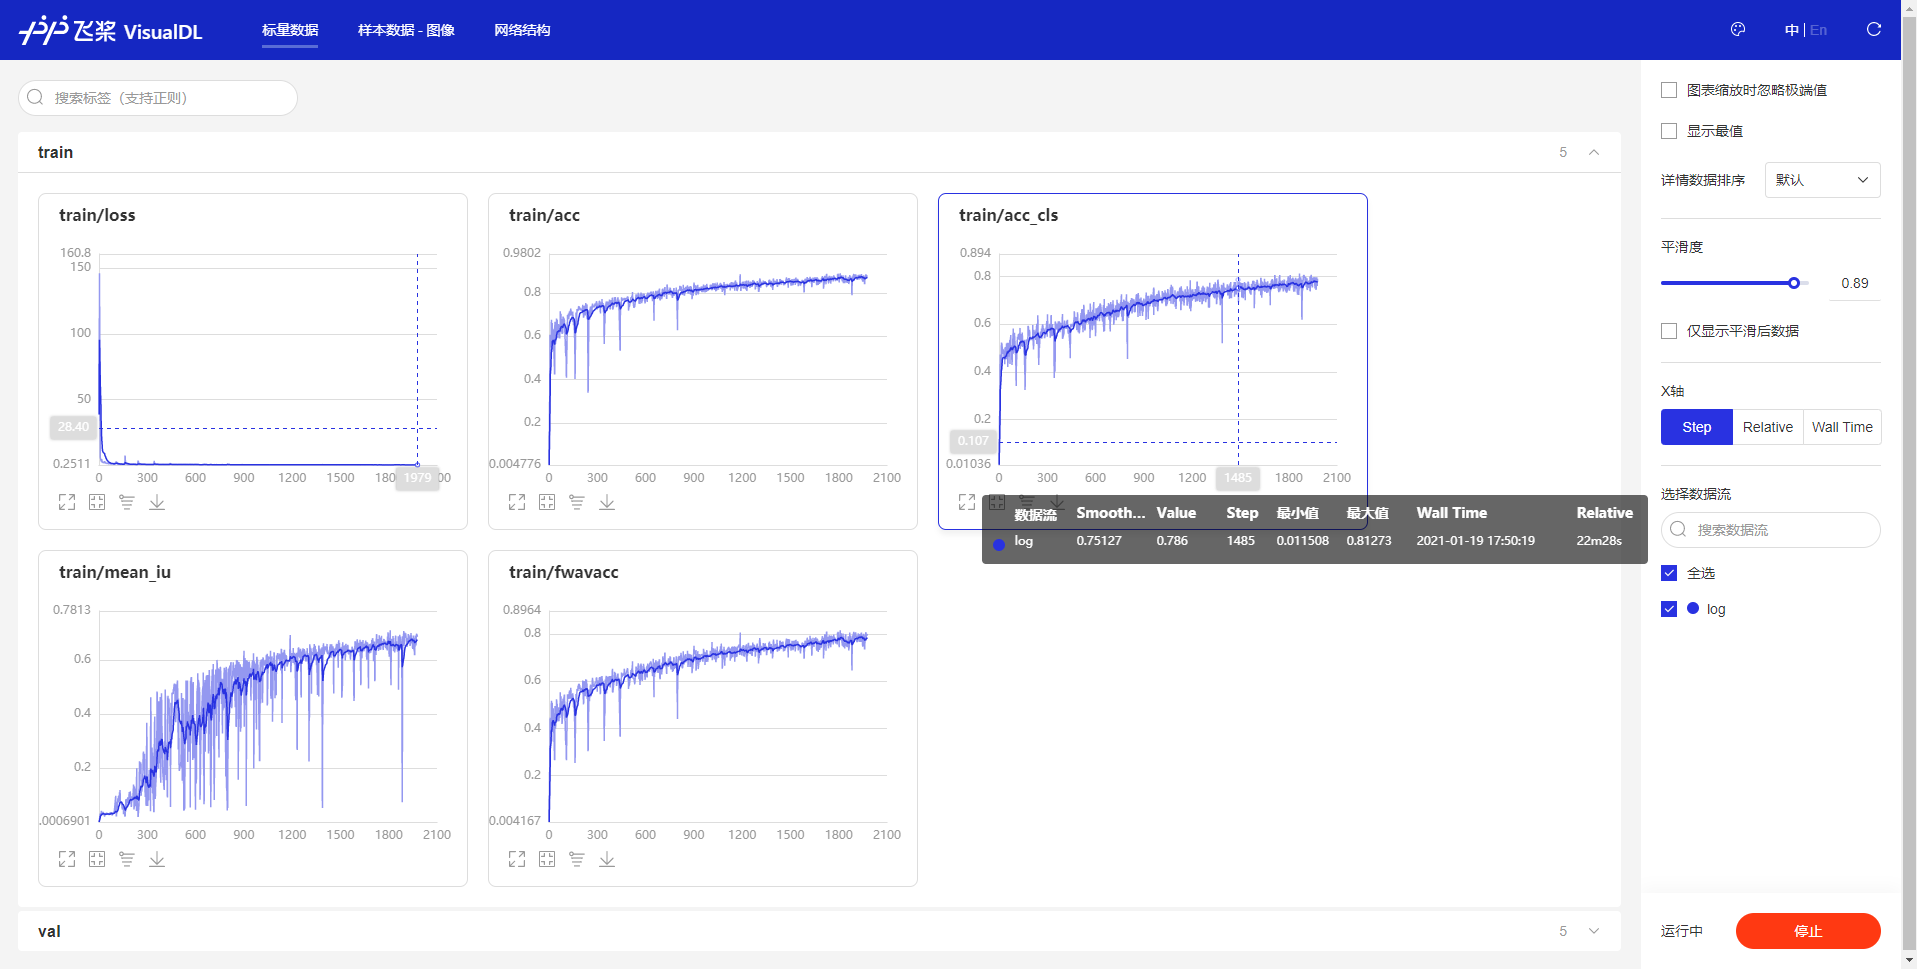

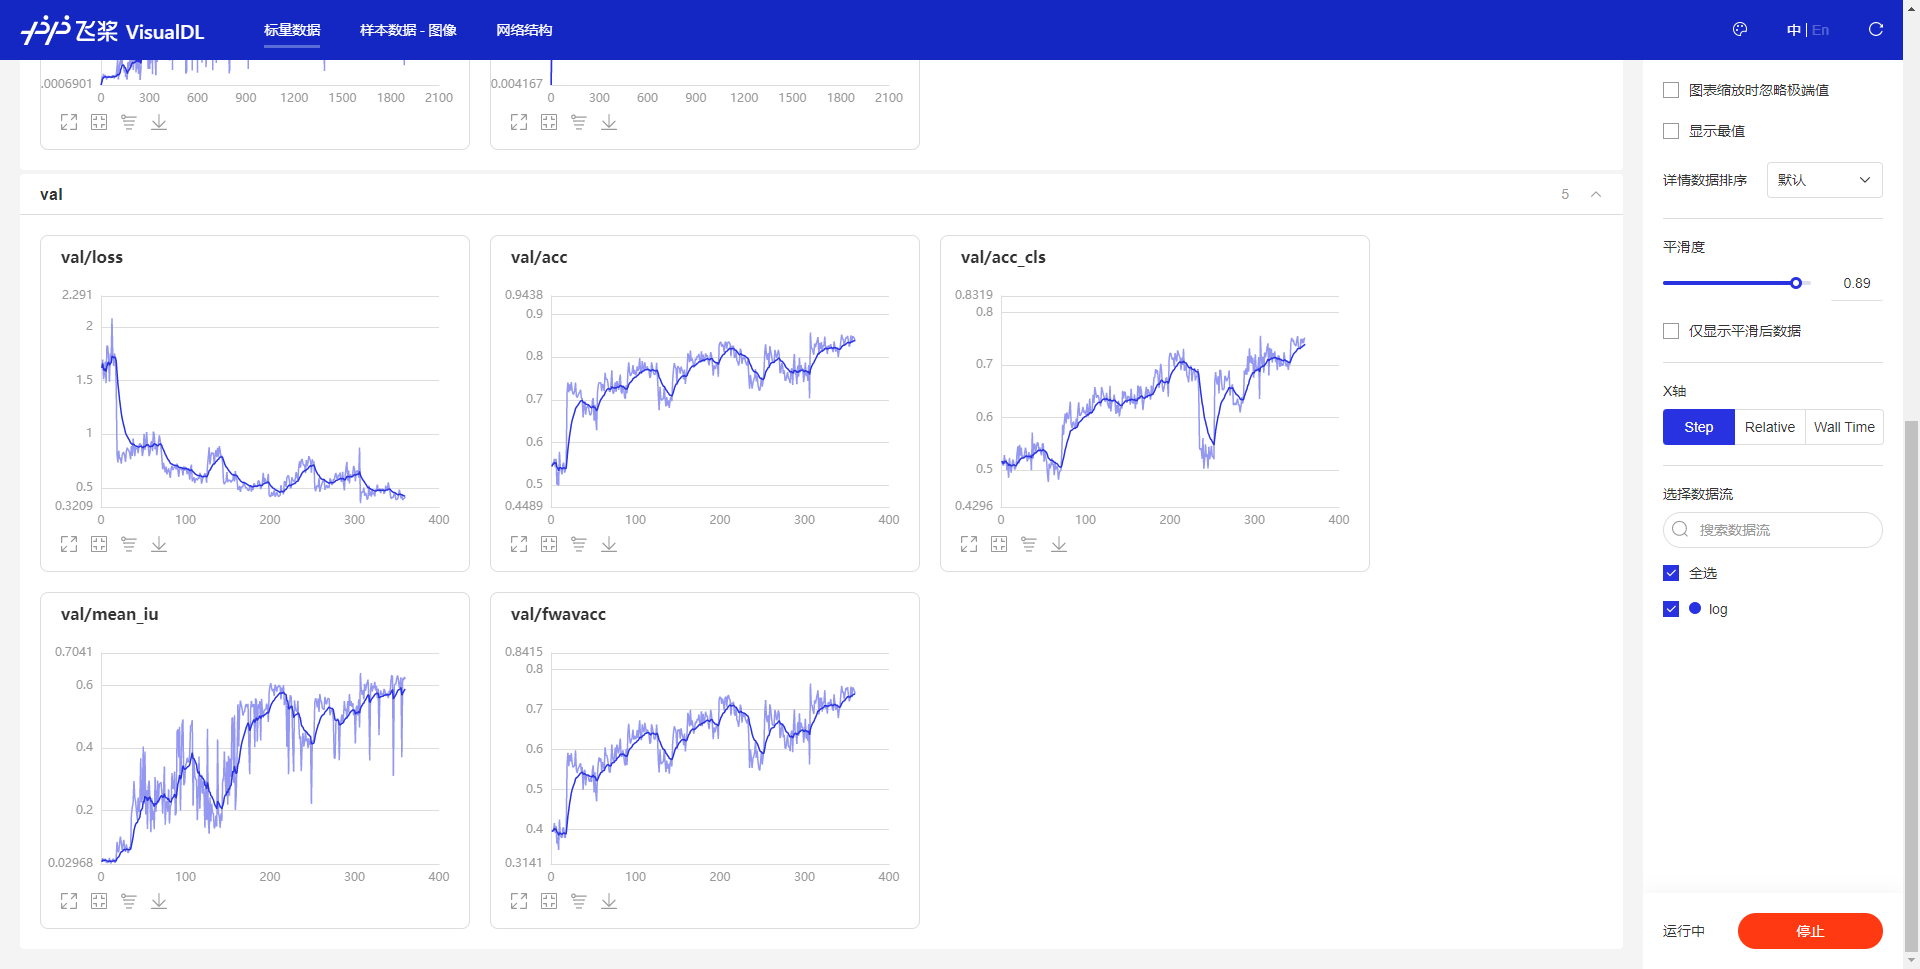

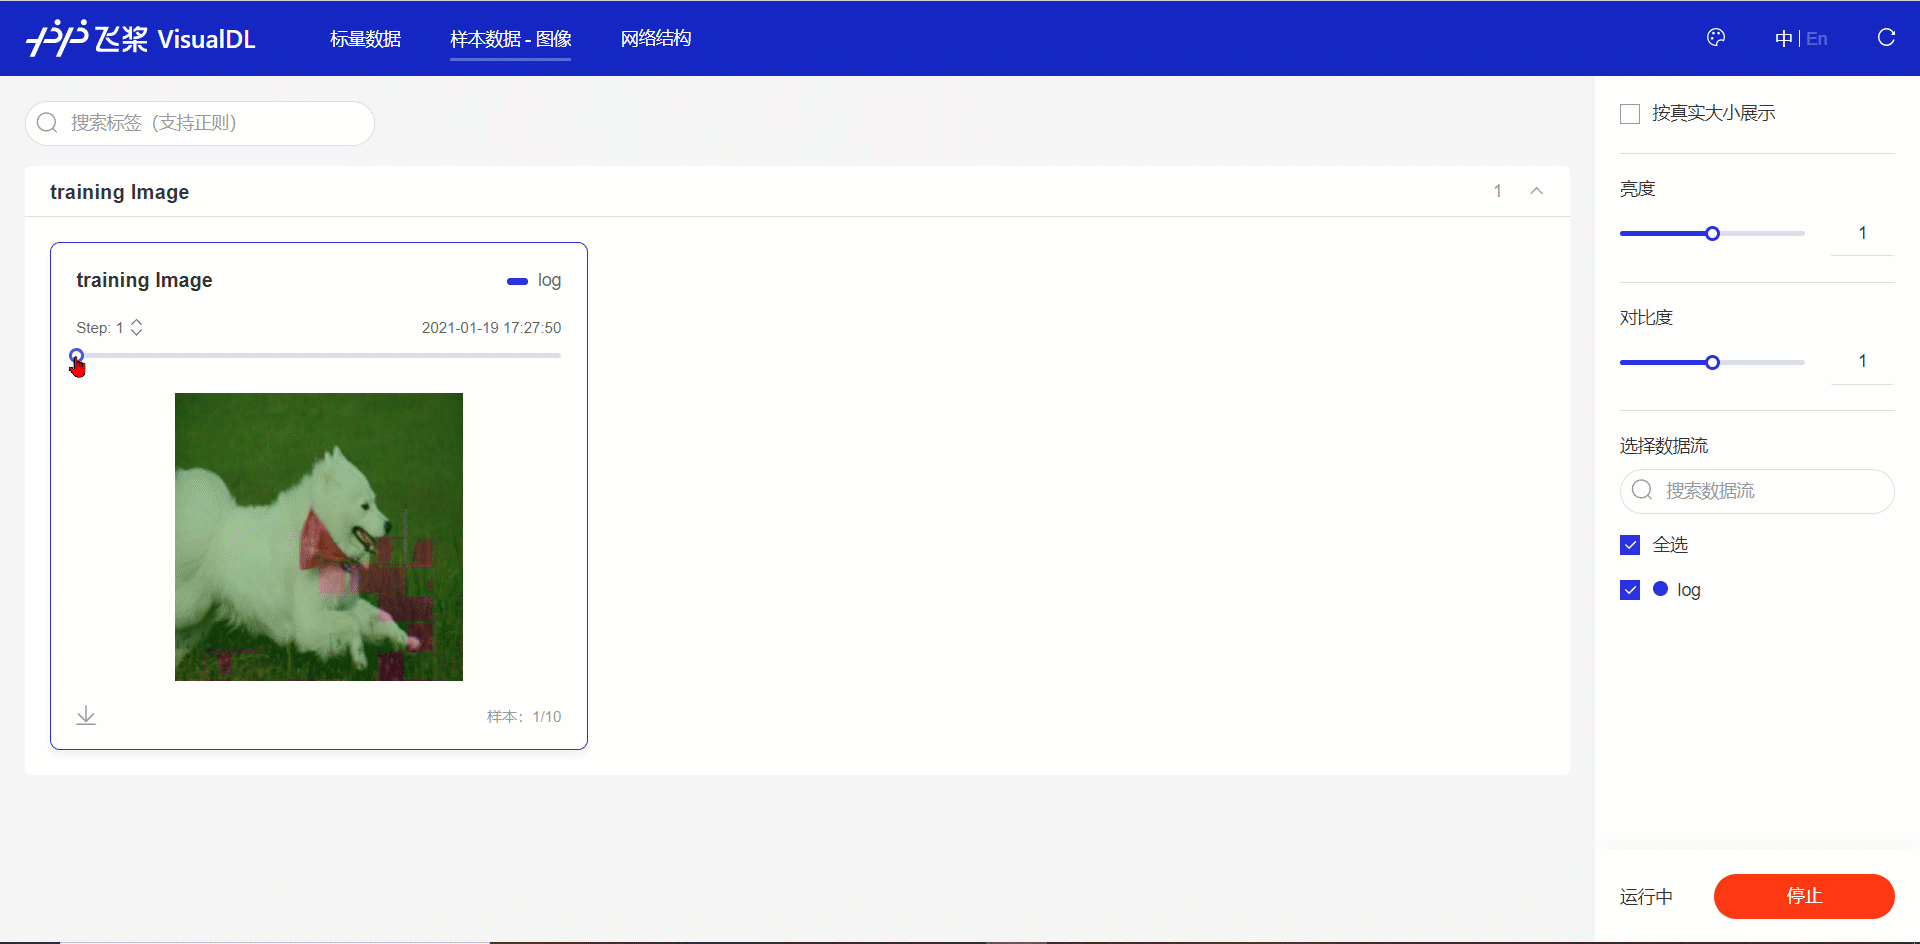